## Imports

In [34]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import pickle
import gzip

tf.random.set_seed(5)

## Data Loading

In [44]:
def convert_x(x):
    '''helper function to convert numpy array to proper format'''
    return x / 255.0 # normalize, and ensure correct indicies for model,  x.transpose(0, 3, 1, 2)

def load_from_pickle_files(prefix, path):
    '''helper function to load pickle files and return the numpy arrays we need'''
    with gzip.open(os.path.join(path, prefix + '_x_train.gz'), 'rb') as i:
        x_train = pickle.load(i)
    with gzip.open(os.path.join(path, prefix + '_x_val.gz'), 'rb') as i:
        x_valid = pickle.load(i)    
    with gzip.open(os.path.join(path, prefix + '_x_test.gz'), 'rb') as i:
        x_test = pickle.load(i)  
    with gzip.open(os.path.join(path, prefix + '_y_train.gz'), 'rb') as i:
        y_train = pickle.load(i)  
    with gzip.open(os.path.join(path, prefix + '_y_val.gz'), 'rb') as i:
        y_valid = pickle.load(i) 
    with gzip.open(os.path.join(path, prefix + '_y_test.gz'), 'rb') as i:
        y_test = pickle.load(i) 
    
    x_train = convert_x(x_train)
    y_train = y_train.flatten()

    x_valid = convert_x(x_valid)
    y_valid = y_valid.flatten()

    x_test = convert_x(x_test)
    y_test = y_test.flatten()

    # convert to tensorflow tensors
    x_train = tf.convert_to_tensor(np.array(x_train, dtype=np.float32), dtype=tf.float32)
    y_train = tf.convert_to_tensor(np.array(y_train, dtype=np.float32), dtype=tf.float32)
    x_test = tf.convert_to_tensor(np.array(x_test, dtype=np.float32), dtype=tf.float32)
    y_test = tf.convert_to_tensor(np.array(y_test, dtype=np.float32), dtype=tf.float32)
    x_valid = tf.convert_to_tensor(np.array(x_valid, dtype=np.float32), dtype=tf.float32)
    y_valid = tf.convert_to_tensor(np.array(y_valid, dtype=np.float32), dtype=tf.float32)

    return x_train, x_valid, x_test, y_train, y_valid, y_test       

In [45]:
path = os.path.join(os.path.dirname(os.getcwd()), 'chest-data')
x_train, x_valid, x_test, y_train, y_valid, y_test = load_from_pickle_files('chest', path)

In [46]:
print(x_test[0].shape)

(64, 64, 3)


## Defining CNN

In [47]:
class CNN(tf.keras.Model):
    def __init__(self, inputshape):
        super().__init__()
        self.conv1 = layers.Conv2D(filters = 16, kernel_size = 3, activation = 'relu', dtype='float32', padding = 'same', input_shape = inputshape)
        self.pool = layers.MaxPool2D(pool_size = 2)
        self.conv2 = layers.Conv2D(filters = 32, kernel_size = 3, activation = 'relu', padding = 'same')
        self.fc1 = layers.Dense(units = 32, activation = 'relu')
        self.fc2 = layers.Dense(units = 10, activation = 'softmax')
        self.flat = layers.Flatten()
            
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.flat(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

## Regular SGD

In [48]:
# hyperparameters
epochs = 100
batch = 100
lr = 0.01

# functions
loss_fcn = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.experimental.SGD(learning_rate=lr)
train_acc_metric = keras.metrics.SparseCategoricalAccuracy()
valid_acc_metric = keras.metrics.SparseCategoricalAccuracy()

In [49]:
def train_sgd(x_train, y_train, x_valid, y_valid, model, epoch_num, batch_size):
    train_accuracies = []
    valid_accuracies = []

    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_dataset = train_dataset.batch(batch_size)

    val_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
    val_dataset = val_dataset.batch(batch_size)

    for epoch in range(epoch_num):
        for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
            with tf.GradientTape() as tape:
                logits = model(x_batch_train, training=True)
                loss_value = loss_fcn(y_batch_train, logits)
            grads = tape.gradient(loss_value, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))
            train_acc_metric.update_state(y_batch_train, logits)
        train_accuracy = float(train_acc_metric.result())
        train_accuracies.append(train_accuracy)
        train_acc_metric.reset_states()

        for step, (x_batch_valid, y_batch_valid) in enumerate(val_dataset):
            val_logits = model(x_batch_valid, training=False)
            valid_acc_metric.update_state(y_batch_valid, val_logits)
        valid_accuracy = float(valid_acc_metric.result())
        valid_accuracies.append(valid_accuracy)
        valid_acc_metric.reset_states()

        print("Epoch", epoch+1, "Training Accuracy: ", train_accuracy, ", Validation Accuracy: ",  valid_accuracy)
    return train_accuracies, valid_accuracies


In [50]:
sgd_model = CNN(x_test[0].shape)
train_accuracies_regular, valid_accuracies_regular = train_sgd(x_train, y_train, x_valid, y_valid, sgd_model, epochs, batch)
output = sgd_model(tf.Variable(x_test))

acc = keras.metrics.SparseCategoricalAccuracy()
acc.update_state(y_test, output)
print(float(acc.result()))

# ind_max_amp=np.argmax(output.numpy(), axis=1, out=None)
# print(np.mean(y_test == ind_max_amp))

Epoch 1 Training Accuracy:  0.6081081032752991 , Validation Accuracy:  0.6996586918830872
Epoch 2 Training Accuracy:  0.6843419671058655 , Validation Accuracy:  0.6808874011039734
Epoch 3 Training Accuracy:  0.7303172945976257 , Validation Accuracy:  0.7184300422668457
Epoch 4 Training Accuracy:  0.771151602268219 , Validation Accuracy:  0.7474402785301208
Epoch 5 Training Accuracy:  0.8012632131576538 , Validation Accuracy:  0.7610921263694763
Epoch 6 Training Accuracy:  0.8444477319717407 , Validation Accuracy:  0.6023890972137451
Epoch 7 Training Accuracy:  0.8561986088752747 , Validation Accuracy:  0.8122866749763489
Epoch 8 Training Accuracy:  0.8798472285270691 , Validation Accuracy:  0.8976109027862549
Epoch 9 Training Accuracy:  0.8874853253364563 , Validation Accuracy:  0.9197952151298523
Epoch 10 Training Accuracy:  0.9021739363670349 , Validation Accuracy:  0.914675772190094
Epoch 11 Training Accuracy:  0.913337230682373 , Validation Accuracy:  0.9095563292503357
Epoch 12 Tr

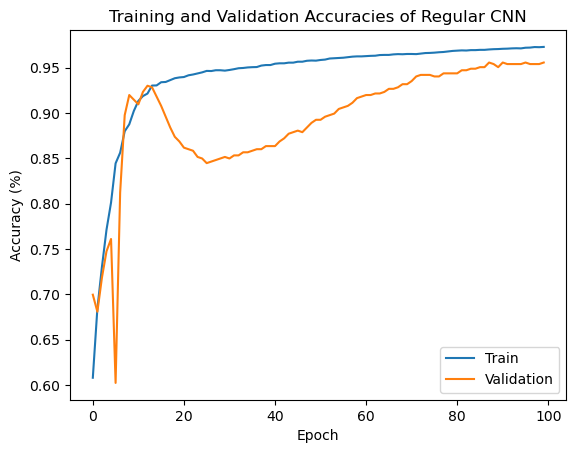

In [51]:
plt.title("Training and Validation Accuracies of Regular CNN")
plt.plot(train_accuracies_regular, label="Train")
plt.plot(valid_accuracies_regular, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend(loc='best')
plt.show()

## DP-SGD-JL

In [67]:
# hyperparameters
epochs = 50
batch = 100
lr = 0.01
sigma = 4
C = 80. 
r = 5 # number of JL projections

# functions
loss_fcn = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
optimizer = tf.keras.optimizers.experimental.SGD(learning_rate=lr)
train_acc_metric = keras.metrics.SparseCategoricalAccuracy()
valid_acc_metric = keras.metrics.SparseCategoricalAccuracy()

In [68]:
def RMS(A):
    return tf.math.sqrt(tf.math.reduce_mean(tf.math.square(A)))

In [69]:
def train_dp_sgd_jl(x_train, y_train, x_valid, y_valid, model, epoch_num, batch_size):
    train_accuracies = []
    valid_accuracies = []

    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_dataset = train_dataset.batch(batch_size)

    val_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
    val_dataset = val_dataset.batch(batch_size)

    # Need to use a test variable to initialize the trainable weights of the model
    test = tf.ones((1, 64, 64, 3))
    output = model(test)
    #print(len(model.trainable_weights))

    for epoch in range(epoch_num):
        for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
            #a = time.time()
            P = []  # store Pij
            M = []  # store per sample gradient norm estimates

            for j in range(r):
                #start = time.time()
                vj = [tf.random.normal(w.shape) for w in model.trainable_weights]
                with tf.autodiff.ForwardAccumulator(model.trainable_weights, vj) as acc:
                    logits = model(x_batch_train, training=True)
                    F = loss_fcn(y_batch_train, logits)
                jvp = acc.jvp(F)
                P.append(jvp)
                #print('Time to complete jvp for v_j:', time.time()-start)

            P = tf.stack(P)

            for i in range(len(x_batch_train)):
                M.append(RMS(tf.gather(P, i, axis=1)))

            M = tf.convert_to_tensor(M, dtype=tf.float32)   # {M_i}
            clipped_M = tf.clip_by_value(M, clip_value_min=-np.inf, clip_value_max=C)   # min{M_i, C}
            scale = tf.math.divide_no_nan(clipped_M, M)     # min{1, C/M_i}

            with tf.GradientTape(persistent=True) as tape:
                logits = model(x_batch_train, training=True)
                F = loss_fcn(y_batch_train, logits)
                average_loss = tf.tensordot(scale, F, 1)/len(scale)

            g = tape.gradient(average_loss, model.trainable_weights)
            coeff = sigma*C/len(x_batch_train)
            noise = [coeff*tf.random.normal(w.shape) for w in model.trainable_weights]
            g = g + noise
            optimizer.apply_gradients(zip(g, model.trainable_weights))
            train_acc_metric.update_state(y_batch_train, logits)

            #print('Time to complete batch:', time.time()-a)

        #print('calculated loss values')

        train_accuracy = float(train_acc_metric.result())
        train_accuracies.append(train_accuracy)
        train_acc_metric.reset_states()

        for step, (x_batch_valid, y_batch_valid) in enumerate(val_dataset):
            val_logits = model(x_batch_valid, training=False)
            valid_acc_metric.update_state(y_batch_valid, val_logits)
        valid_accuracy = float(valid_acc_metric.result())
        valid_accuracies.append(valid_accuracy)
        valid_acc_metric.reset_states()

        print("Epoch", epoch+1, ", Training Accuracy: ", train_accuracy, "Validation Accuracy: ",  valid_accuracy) # "Training Accuracy: ", train_accuracy, 
    return train_accuracies, valid_accuracies #train_accuracies, 

In [70]:
dp_sgd_jl_model = CNN(x_test[0].shape)
train_accuracies_dp, valid_accuracies_dp = train_dp_sgd_jl(x_train, y_train, x_valid, y_valid, dp_sgd_jl_model, epochs, batch)
output = dp_sgd_jl_model(tf.Variable(x_test))

acc = keras.metrics.SparseCategoricalAccuracy()
acc.update_state(y_test, output)
print(float(acc.result()))

Epoch 1 , Training Accuracy:  0.6317567825317383 Validation Accuracy:  0.7133105993270874
Epoch 2 , Training Accuracy:  0.7144535779953003 Validation Accuracy:  0.8037542700767517
Epoch 3 , Training Accuracy:  0.7849588990211487 Validation Accuracy:  0.8686006665229797
Epoch 4 , Training Accuracy:  0.8062573671340942 Validation Accuracy:  0.8924914598464966
Epoch 5 , Training Accuracy:  0.8491480350494385 Validation Accuracy:  0.8378839492797852
Epoch 6 , Training Accuracy:  0.8714747428894043 Validation Accuracy:  0.8686006665229797
Epoch 7 , Training Accuracy:  0.8917450308799744 Validation Accuracy:  0.9078498482704163
Epoch 8 , Training Accuracy:  0.8968859910964966 Validation Accuracy:  0.9163822531700134
Epoch 9 , Training Accuracy:  0.913337230682373 Validation Accuracy:  0.9163822531700134
Epoch 10 , Training Accuracy:  0.9180375933647156 Validation Accuracy:  0.9180887341499329
Epoch 11 , Training Accuracy:  0.9221504330635071 Validation Accuracy:  0.9300341010093689
Epoch 12 

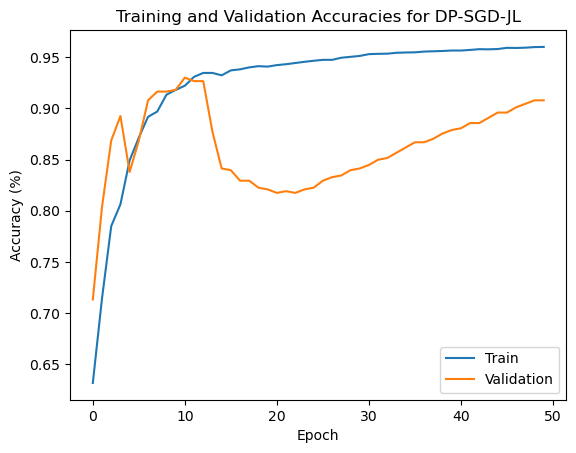

In [71]:
plt.title("Training and Validation Accuracies for DP-SGD-JL")
plt.plot(train_accuracies_dp, label="Train")
plt.plot(valid_accuracies_dp, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend(loc='best')
plt.show()